In [11]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import matplotlib.patches as mpatches

In [12]:
sns.set_style("darkgrid")

figsize = (10,7)
INIT_COL = sns.color_palette('colorblind')[0]
RESP_COL = sns.color_palette('colorblind')[1]

ID = "0606"
figure_path = "figs" + os.sep + ID + os.sep

if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    
PARETO = False

In [13]:
directory = "../results/results_" + ID + "_determineProbCompare"
idx = 0
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if not filename.endswith(".csv"):
        continue
    newdata = pd.read_csv(f, index_col = None)
    if (idx == 0):
        data = newdata
    else:
        data = pd.concat([data, newdata], ignore_index = True)
    idx += 1
    
print("Number of observations: " + str(len(data.index)))
print("Number of observations per group: " + str(len(data.index) / 24))

Number of observations: 24000
Number of observations per group: 1000.0


In [14]:
# data = data.loc[(data["init_highestValueParetoOutcome"] != -1) & (data["resp_highestValueParetoOutcome"] != -1)]

In [15]:
if PARETO:
    data = data.loc[(data["init_highestValueParetoOutcome"] != -1) & (data["resp_highestValueParetoOutcome"] != -1)]
df = copy.deepcopy(data[["init_tom", "resp_tom", "init_canLie", "resp_canLie", "init_numberOfMessagesSent",
           "resp_numberOfMessagesSent", "init_numberOfTimesLied", "resp_numberOfTimesLied", "nr_offers"]])

In [16]:
df["init_nr_offers"] = df.apply(lambda x: x["nr_offers"] / 2 if (x["nr_offers"] % 2 == 0) else ((x["nr_offers"] + 1) / 2), axis=1)
df["resp_nr_offers"] = df.apply(lambda x: x["nr_offers"] / 2 if (x["nr_offers"] % 2 == 0) else ((x["nr_offers"] - 1) / 2), axis=1)

In [17]:
df_results = pd.DataFrame(columns=["name", "count", "nr_offers", "nr_of_messages", "nr_of_times_lied"])
df_results.loc[0] = ["two_canLie", 0, 0, 0, 0]
df_results.loc[1] = ["two_cannotLie", 0, 0, 0, 0]
df_results.loc[2] = ["one_canLie", 0, 0, 0, 0]
df_results.loc[3] = ["one_cannotLie", 0, 0, 0, 0]

df_results = df_results.set_index("name", drop=False)
for index, row in df.iterrows():
    if ((row["init_tom"] == 1) and (row["init_canLie"] == True)):
        df_results.loc["one_canLie", "nr_offers"] += row["init_nr_offers"]
        df_results.loc["one_canLie", "nr_of_messages"] += row["init_numberOfMessagesSent"]
        df_results.loc["one_canLie", "nr_of_times_lied"] += row["init_numberOfTimesLied"]
        df_results.loc["one_canLie", "count"] += 1
    elif ((row["init_tom"] == 1) and (row["init_canLie"] == False)):
        df_results.loc["one_cannotLie", "nr_offers"] += row["init_nr_offers"]
        df_results.loc["one_cannotLie", "nr_of_messages"] += row["init_numberOfMessagesSent"]
        df_results.loc["one_cannotLie", "nr_of_times_lied"] += row["init_numberOfTimesLied"]
        df_results.loc["one_cannotLie", "count"] += 1
    elif ((row["init_tom"] == 2) and (row["init_canLie"] == True)):
        df_results.loc["two_canLie", "nr_offers"] += row["init_nr_offers"]
        df_results.loc["two_canLie", "nr_of_messages"] += row["init_numberOfMessagesSent"]
        df_results.loc["two_canLie", "nr_of_times_lied"] += row["init_numberOfTimesLied"]
        df_results.loc["two_canLie", "count"] += 1
    elif ((row["init_tom"] == 2) and (row["init_canLie"] == False)):
        df_results.loc["two_cannotLie", "nr_offers"] += row["init_nr_offers"]
        df_results.loc["two_cannotLie", "nr_of_messages"] += row["init_numberOfMessagesSent"]
        df_results.loc["two_cannotLie", "nr_of_times_lied"] += row["init_numberOfTimesLied"]
        df_results.loc["two_cannotLie", "count"] += 1
        
    if ((row["resp_tom"] == 1) and (row["resp_canLie"] == True)):
        df_results.loc["one_canLie", "nr_offers"] += row["resp_nr_offers"]
        df_results.loc["one_canLie", "nr_of_messages"] += row["resp_numberOfMessagesSent"]
        df_results.loc["one_canLie", "nr_of_times_lied"] += row["resp_numberOfTimesLied"]
        df_results.loc["one_canLie", "count"] += 1
    elif ((row["resp_tom"] == 1) and (row["resp_canLie"] == False)):
        df_results.loc["one_cannotLie", "nr_offers"] += row["resp_nr_offers"]
        df_results.loc["one_cannotLie", "nr_of_messages"] += row["resp_numberOfMessagesSent"]
        df_results.loc["one_cannotLie", "nr_of_times_lied"] += row["resp_numberOfTimesLied"]
        df_results.loc["one_cannotLie", "count"] += 1
    elif ((row["resp_tom"] == 2) and (row["resp_canLie"] == True)):
        df_results.loc["two_canLie", "nr_offers"] += row["resp_nr_offers"]
        df_results.loc["two_canLie", "nr_of_messages"] += row["resp_numberOfMessagesSent"]
        df_results.loc["two_canLie", "nr_of_times_lied"] += row["resp_numberOfTimesLied"]
        df_results.loc["two_canLie", "count"] += 1
    elif ((row["resp_tom"] == 2) and (row["resp_canLie"] == False)):
        df_results.loc["two_cannotLie", "nr_offers"] += row["resp_nr_offers"]
        df_results.loc["two_cannotLie", "nr_of_messages"] += row["resp_numberOfMessagesSent"]
        df_results.loc["two_cannotLie", "nr_of_times_lied"] += row["resp_numberOfTimesLied"]
        df_results.loc["two_cannotLie", "count"] += 1
      
df_results.loc["total"] = ["total", sum(df_results["count"]), sum(df_results["nr_offers"]),
                           sum(df_results["nr_of_messages"]), sum(df_results["nr_of_times_lied"])]
df_results["percentage_send_messages"] = df_results.apply(lambda x: x["nr_of_messages"] / x["nr_offers"], axis=1)
df_results

,name,count,nr_offers,nr_of_messages,nr_of_times_lied,percentage_send_messages
name,,,,,,
two_canLie,two_canLie,10000,12048,4801,2768,0.398489
two_cannotLie,two_cannotLie,10000,12278,3973,0,0.323587
one_canLie,one_canLie,10000,13443,3538,3220,0.263185
one_cannotLie,one_cannotLie,10000,13128,1413,0,0.107633
total,total,40000,50897,13725,5988,0.269662


C:\Users\sverr\AppData\Local\Temp\ipykernel_7480\2416148901.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_labels)


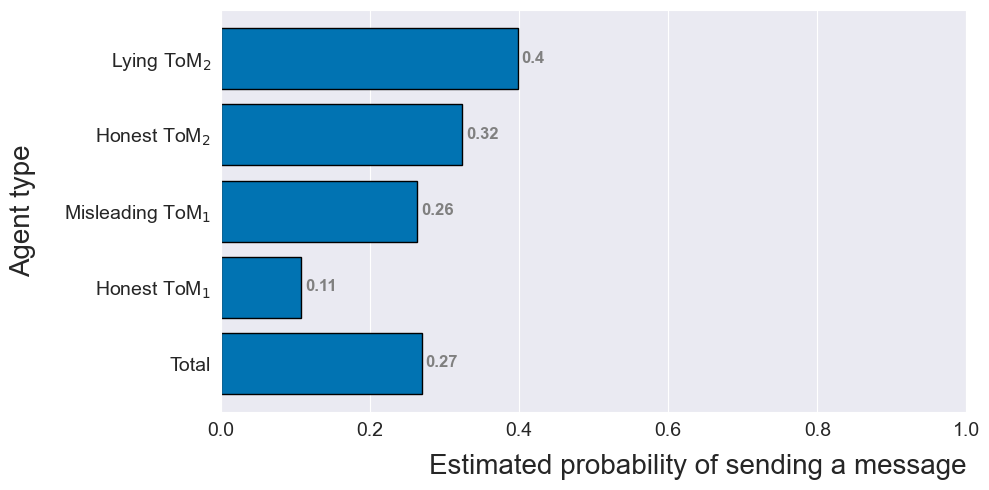

In [18]:
BIN_WIDTH = 0.4
TICK_SIZE = 14
VALUE_SIZE = 12
LABEL_SIZE = 20
figure_size = (10,5)

def make_plot(data):
    fig, ax = plt.subplots(figsize = figure_size)
    
    names = data.index
     
    ax.barh(names, data["percentage_send_messages"], edgecolor="black", color=INIT_COL)
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.005, i.get_y()+0.45,
                str(round((i.get_width()), 2)),
                fontsize = VALUE_SIZE, fontweight ='bold',
                color ='grey')
    
    ax.set_xlim(right=1.0, left=0.0)
    
    ax.yaxis.grid(False)
    ax.xaxis.grid(True, which="both")
    
    y_labels = [r"Lying ToM$_2$", 
                r"Honest ToM$_2$",
                r"Misleading ToM$_1$", 
                r"Honest ToM$_1$",
                "Total"]
    
    
    ax.set_yticklabels(y_labels)
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    
    ax.invert_yaxis()
    
    ax.set_ylabel("Agent type", fontsize=LABEL_SIZE, labelpad=20)
    ax.set_xlabel("Estimated probability of sending a message", fontsize=LABEL_SIZE, loc="right", labelpad=10)
    
    fig.tight_layout()
    # plt.minorticks_on()
    
make_plot(df_results)
if PARETO:
    plt.savefig(figure_path + "barplot_pareto.pdf")
else:
    plt.savefig(figure_path + "barplot.pdf")

In [19]:
df_results_sep = pd.DataFrame(columns=["name", "count", "nr_offers", "nr_of_messages", "nr_of_times_lied"])
df_results_sep.loc[0] = ["init_two_canLie", 0, 0, 0, 0]
df_results_sep.loc[1] = ["resp_two_canLie", 0, 0, 0, 0]
df_results_sep.loc[2] = ["init_two_cannotLie", 0, 0, 0, 0]
df_results_sep.loc[3] = ["resp_two_cannotLie", 0, 0, 0, 0]
df_results_sep.loc[4] = ["init_one_canLie", 0, 0, 0, 0]
df_results_sep.loc[5] = ["resp_one_canLie", 0, 0, 0, 0]
df_results_sep.loc[6] = ["init_one_cannotLie", 0, 0, 0, 0]
df_results_sep.loc[7] = ["resp_one_cannotLie", 0, 0, 0, 0]

df_results_sep = df_results_sep.set_index("name", drop=False)
for index, row in df.iterrows():
    if ((row["init_tom"] == 1) and (row["init_canLie"] == True)):
        df_results_sep.loc["init_one_canLie", "nr_offers"] += row["init_nr_offers"]
        df_results_sep.loc["init_one_canLie", "nr_of_messages"] += row["init_numberOfMessagesSent"]
        df_results_sep.loc["init_one_canLie", "nr_of_times_lied"] += row["init_numberOfTimesLied"]
        df_results_sep.loc["init_one_canLie", "count"] += 1
    elif ((row["init_tom"] == 1) and (row["init_canLie"] == False)):
        df_results_sep.loc["init_one_cannotLie", "nr_offers"] += row["init_nr_offers"]
        df_results_sep.loc["init_one_cannotLie", "nr_of_messages"] += row["init_numberOfMessagesSent"]
        df_results_sep.loc["init_one_cannotLie", "nr_of_times_lied"] += row["init_numberOfTimesLied"]
        df_results_sep.loc["init_one_cannotLie", "count"] += 1
    elif ((row["init_tom"] == 2) and (row["init_canLie"] == True)):
        df_results_sep.loc["init_two_canLie", "nr_offers"] += row["init_nr_offers"]
        df_results_sep.loc["init_two_canLie", "nr_of_messages"] += row["init_numberOfMessagesSent"]
        df_results_sep.loc["init_two_canLie", "nr_of_times_lied"] += row["init_numberOfTimesLied"]
        df_results_sep.loc["init_two_canLie", "count"] += 1
    elif ((row["init_tom"] == 2) and (row["init_canLie"] == False)):
        df_results_sep.loc["init_two_cannotLie", "nr_offers"] += row["init_nr_offers"]
        df_results_sep.loc["init_two_cannotLie", "nr_of_messages"] += row["init_numberOfMessagesSent"]
        df_results_sep.loc["init_two_cannotLie", "nr_of_times_lied"] += row["init_numberOfTimesLied"]
        df_results_sep.loc["init_two_cannotLie", "count"] += 1
        
    if ((row["resp_tom"] == 1) and (row["resp_canLie"] == True)):
        df_results_sep.loc["resp_one_canLie", "nr_offers"] += row["resp_nr_offers"]
        df_results_sep.loc["resp_one_canLie", "nr_of_messages"] += row["resp_numberOfMessagesSent"]
        df_results_sep.loc["resp_one_canLie", "nr_of_times_lied"] += row["resp_numberOfTimesLied"]
        df_results_sep.loc["resp_one_canLie", "count"] += 1
    elif ((row["resp_tom"] == 1) and (row["resp_canLie"] == False)):
        df_results_sep.loc["resp_one_cannotLie", "nr_offers"] += row["resp_nr_offers"]
        df_results_sep.loc["resp_one_cannotLie", "nr_of_messages"] += row["resp_numberOfMessagesSent"]
        df_results_sep.loc["resp_one_cannotLie", "nr_of_times_lied"] += row["resp_numberOfTimesLied"]
        df_results_sep.loc["resp_one_cannotLie", "count"] += 1
    elif ((row["resp_tom"] == 2) and (row["resp_canLie"] == True)):
        df_results_sep.loc["resp_two_canLie", "nr_offers"] += row["resp_nr_offers"]
        df_results_sep.loc["resp_two_canLie", "nr_of_messages"] += row["resp_numberOfMessagesSent"]
        df_results_sep.loc["resp_two_canLie", "nr_of_times_lied"] += row["resp_numberOfTimesLied"]
        df_results_sep.loc["resp_two_canLie", "count"] += 1
    elif ((row["resp_tom"] == 2) and (row["resp_canLie"] == False)):
        df_results_sep.loc["resp_two_cannotLie", "nr_offers"] += row["resp_nr_offers"]
        df_results_sep.loc["resp_two_cannotLie", "nr_of_messages"] += row["resp_numberOfMessagesSent"]
        df_results_sep.loc["resp_two_cannotLie", "nr_of_times_lied"] += row["resp_numberOfTimesLied"]
        df_results_sep.loc["resp_two_cannotLie", "count"] += 1
      
df_results_temp = df_results_sep.loc[["init_two_canLie", "init_two_cannotLie", "init_one_canLie", "init_one_cannotLie"]]
df_results_sep.loc["total_init"] = ["total_init", sum(df_results_temp["count"]), sum(df_results_temp["nr_offers"]),
                           sum(df_results_temp["nr_of_messages"]), sum(df_results_temp["nr_of_times_lied"])]
df_results_temp = df_results_sep.loc[["resp_two_canLie", "resp_two_cannotLie", "resp_one_canLie", "resp_one_cannotLie"]]
df_results_sep.loc["total_resp"] = ["total_resp", sum(df_results_temp["count"]), sum(df_results_temp["nr_offers"]),
                           sum(df_results_temp["nr_of_messages"]), sum(df_results_temp["nr_of_times_lied"])]
df_results_sep["percentage_send_messages"] = df_results_sep.apply(lambda x: x["nr_of_messages"] / x["nr_offers"], axis=1)
df_results_sep

,name,count,nr_offers,nr_of_messages,nr_of_times_lied,percentage_send_messages
name,,,,,,
init_two_canLie,init_two_canLie,5000,7315,2594,1389,0.354614
resp_two_canLie,resp_two_canLie,5000,4733,2207,1379,0.466300
init_two_cannotLie,init_two_cannotLie,5000,7411,2078,0,0.280394
resp_two_cannotLie,resp_two_cannotLie,5000,4867,1895,0,0.389357
init_one_canLie,init_one_canLie,5000,7766,2174,1987,0.279938
resp_one_canLie,resp_one_canLie,5000,5677,1364,1233,0.240268
init_one_cannotLie,init_one_cannotLie,5000,7595,773,0,0.101777
resp_one_cannotLie,resp_one_cannotLie,5000,5533,640,0,0.115670
total_init,total_init,20000,30087,7619,3376,0.253232


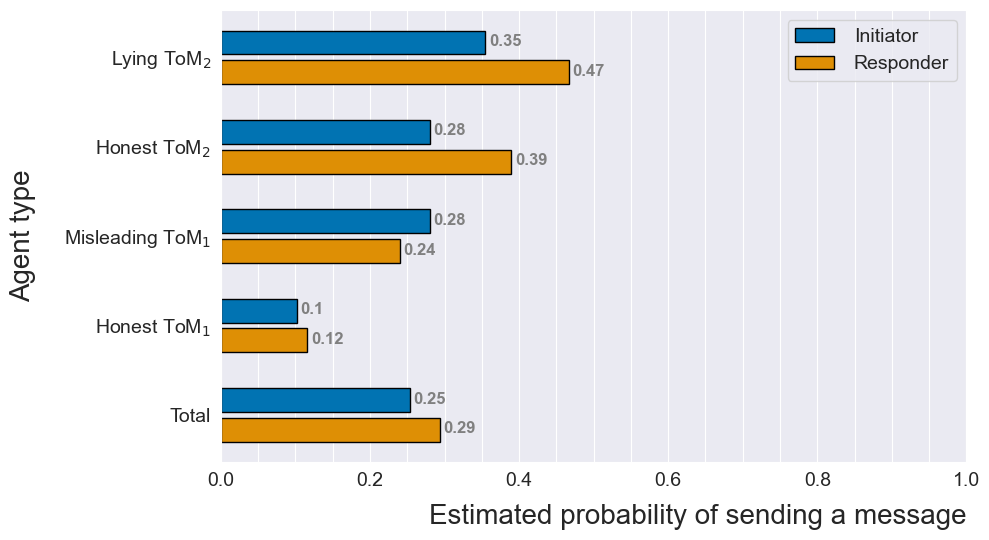

In [20]:
BIN_WIDTH = 0.4
TICK_SIZE = 14
VALUE_SIZE = 12
LABEL_SIZE = 20
fig_size=(10,5.5)

def make_plot(data):
    fig, ax = plt.subplots(figsize = fig_size)
    
    pos = [0, 1, 3, 4, 6, 7, 9, 10, 12, 13]
    names = data.index
    
    for idx, name in enumerate(names):
        color = INIT_COL if (name.find("init") >= 0) else RESP_COL
        ax.barh(pos[idx], data["percentage_send_messages"].loc[name], color=color, edgecolor="black")
        
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.005, i.get_y()+0.52,
                str(round((i.get_width()), 2)),
                fontsize = VALUE_SIZE, fontweight ='bold',
                color ='grey')
    
    ax.set_xlim(right=1.0, left=0.0)
    
    ax.yaxis.grid(False)
    ax.xaxis.grid(True, which="both")
    
    y_ticks = []
    for i in range(0, len(pos),2):
        y_ticks.append((pos[i] + pos[i+1]) / 2)
    y_labels = [r"Lying ToM$_2$", 
                r"Honest ToM$_2$",
                r"Misleading ToM$_1$", 
                r"Honest ToM$_1$",
                "Total"]
    
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    
    ax.invert_yaxis()
    ax.legend((mpatches.Patch(facecolor=INIT_COL, edgecolor='black', label="Initiator"),
            mpatches.Patch(facecolor=RESP_COL, edgecolor='black', label="Responder")),
              ("Initiator" , "Responder"), fontsize=TICK_SIZE, ncol=1, fancybox=True, loc="upper right",
              handletextpad=1)
    
    ax.set_ylabel("Agent type", fontsize=LABEL_SIZE, labelpad=20)
    ax.set_xlabel("Estimated probability of sending a message", fontsize=LABEL_SIZE, loc="right", labelpad=10)
    
    fig.tight_layout()
    plt.minorticks_on()
    
    
make_plot(df_results_sep)
if PARETO:
    plt.savefig(figure_path + "barplot_separate_pareto.pdf")
else:
    plt.savefig(figure_path + "barplot_separate.pdf")